#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

# Outline

<a name="outline"></a>

- [Section 1](#section-1): Data generation
- [Section 2](#section-2): Gaussian Mixture Model
- [Section 3](#section-3): Fitting Gaussian Mixture Models using the EM algorithm
- [Section 4](#section-4): Clustering of breast cancer data

# Clustering using Gaussian Mixture Models
In this notebook, we implemenet clustering via Gaussian Mixture Models. We will first generate some synthetic data and define a Gaussian Mixture Model class (`GMModel`) before using the expectation-maximisation algorithm to optimise the model parameter.



In [48]:
# import libraries
import numpy as np
import numpy.testing as npt
import pandas as pd
import matplotlib.pyplot as plt
import copy
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<a name="section-1"></a>
# Section 1: Data generation ([index](#outline))

Sampling Gaussian mixtures is relatively straightforward. We define a function `synthetic_data` to generate data from two mixtures with the given parameters.

In [49]:
def synthetic_data(mean_a, mean_b, cov, n, rng):
    """
    Generates synthetic data from a Gaussian Mixture Model with two mixtures.

    Parameters:
      mean_a (np.ndarray): The mean of the first Gaussian distribution, shape (p,).
      mean_b (np.ndarray): The mean of the second Gaussian distribution, shape (p,).
      cov (np.ndarray): The covariance matrix of the Gaussian distributions, shape (p, p).
      n (int): The number of data points to generate.
      rng (np.random.Generator): A random number generator.

    Returns:
      np.ndarray: An array of the generated data points, shape (N, p).
    """

    a = rng.multivariate_normal(mean_a, cov, size=n)
    b = rng.multivariate_normal(mean_b, cov, size=n)
    return np.vstack((a, b)) # combine

We now generate some data.

In [50]:
rng = np.random.default_rng(0) # Set seed for reproducibility.

# Define covariance of Gaussians
cov = np.array([[6, -3], [-3, 3.5]])

# Define means of Gaussians
mean_a = np.array([0, 0])
mean_b = np.array([10, 5])

n = 50
data = synthetic_data(mean_a, mean_b, cov, n, rng)
mixture_id = np.concatenate((np.zeros(n), np.ones(n)))

When can then visualise the data we generated here below.



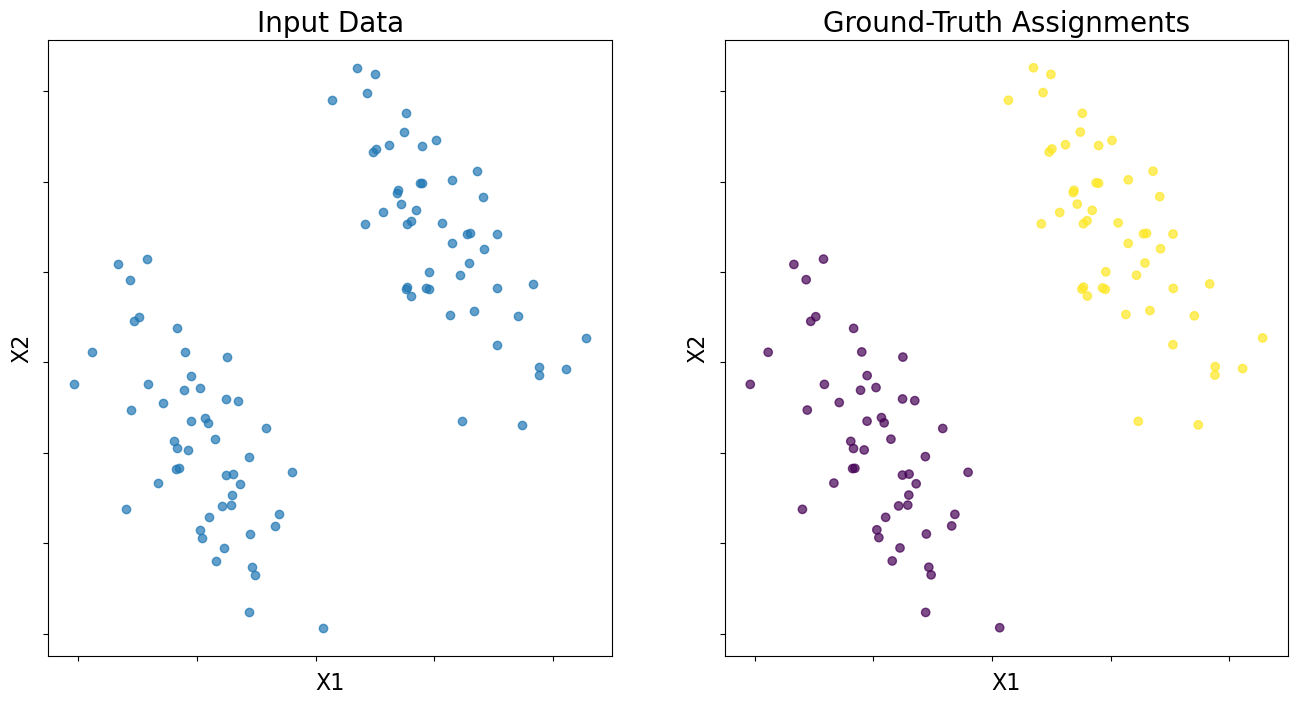

In [51]:
# Visualise the data
fig = plt.figure(figsize=(16, 8))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)

ax1.scatter(data[:, 0], data[:, 1], alpha=0.7)
ax1.set_title('Input Data')
ax1.set_xticklabels([]); ax1.set_yticklabels([])
ax1.set_xlabel('X1'); ax1.set_ylabel('X2')
# We use cluster_assignment here only to visualise the ground-truth
# (the ideal clustering) in practice we don't have it and aim to it
ax2.scatter(data[:, 0], data[:, 1], alpha=0.7, c=mixture_id, cmap='viridis')
ax2.set_title('Ground-Truth Assignments')
ax2.set_xticklabels([]); ax2.set_yticklabels([])
ax2.set_xlabel('X1'); ax2.set_ylabel('X2')

# Show the plot
plt.show()

<a name="section-2"></a>
# Section 2: Gaussian Mixture Model ([index](#outline))

Following the lecture notes, the Gaussian Mixture Model (GMM) is given by:
$$
P(\mathbf{x}=\mathbf{x}^{(i)}) = \sum_{k=1}^K \pi_k p_k(\mathbf{x}^{(i)}|\mathbf{\theta})\, .
$$
where $K$ is the number of clusters described as mixture components each of which are multivariate normal distributions:
$$
p_k(\mathbf{x}|\mathbf{\theta}) = {\displaystyle (2\pi )^{-p/2}\det({\boldsymbol {\Sigma }_k})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }_k})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }_k}^{-1}(\mathbf {x} -{\boldsymbol {\mu }_k})\right),}
$$
where $\boldsymbol{\theta} = \{\pi_k,\mathbf{\mu}_k, \mathbf{\Sigma}_k \}_{k=1,2,...,K}$ is the vector of parameters consiting of the mixture weights $\pi_k$, mixture component means $\boldsymbol{\mu}_k$ and mixture component covariance matrices $\boldsymbol{\Sigma}_k$.

We start by implementing a class `MultivariateNormal` which defines a multivariate normal distribution and contains a method `pdf`.

In [52]:
## EDIT THIS FUNCTION
class MultivariateNormal():
    """
    Multivariate normal distribution.

    Parameters:
      mean (np.ndarray): the mean of the distribution, shape (p,).
      cov (np.ndarray): the covariance matrix of the distribution, shape (p, p).
    """

    def __init__(self, mean, cov):
        """Initialises the multivariate normal distribution."""
        self.mean = mean
        self.cov = cov
        self.cov_inv = np.linalg.inv(cov)
        self.cov_det = np.linalg.det(cov)
        self.p = cov.shape[0]

    def pdf(self, X):
        """
        Computes the probability density function of the distribution.

        Parameters:
            X (np.ndarray): the data points, shape (N, p).

        Returns:
            np.ndarray: the probability density function values, shape (N,).
        """
        # Tip: you need to be careful with the dimensions to ensure you output the shape you expect
        matrix_factor = -0.5 * np.sum((X - self.mean) @ self.cov_inv * (X - self.mean), axis=1)  ## <- EDIT HERE
        return np.exp(matrix_factor) * (2 * np.pi) ** (- self.p / 2) * (self.cov_det) ** (-0.5)

This should pass the following simple test case.

In [53]:
X_testing = np.array([[1.0, 2.0],
                      [3.0, -1.0],
                      [-3.0, 1.0]])
expected_output = np.array([0.022799327319919294, 0.006532116642342461, 0.006532116642342461])
npt.assert_allclose(MultivariateNormal(np.array([0,0]), 2*np.eye(2)).pdf(X_testing), expected_output)

We now define a class for the GMM model.

**Initialisation:**  The samples are randomly split into $K$  groups and the means of these groups are taken as the initial values of the means. The covariance matrix is initialised as the covariance matrix of the data.

In [54]:
class GMModel:
    """
    Class to define Gaussian Mixture Model.

    Parameters:
      X (np.ndarray): the samples array, shape (N, p).
      k (int): number of mixture components, i.e. number of clusters.

    Attributes:
      pi (np.ndarray): mixture weights, shape(k,).
      weights (np.ndarray): mixture weights, shape (N, p).
      mu (list): mixture component means for each cluster.
      sigma (list): mixture component covariance matrix for each cluster.
    """

    def __init__(self, X, k, rng):
        """Initialises parameters."""
        self.k = k

        # initial weights given to each cluster are stored in pi, pi_k
        self.pi = np.full(shape=self.k, fill_value=1/self.k)

        # initial weights given to each data point wrt to each cluster or w_ik(theta)
        self.weights = np.full(shape=X.shape, fill_value=1/self.k)

        # initial value of mean of k Gaussians
        indices = np.arange(X.shape[0])
        rng.shuffle(indices)
        random_samples = np.array_split(indices, self.k)
        self.mu = [X[row_index,:].mean(axis=0) for row_index in random_samples]

        # initial value of covariance matrix of k Gaussians
        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def copy(self):
        """Return an isolated copy."""
        return copy.deepcopy(self)

We can perform 'soft' clustering of the data by calculating the cluster probabilities of the data:
$$r_{ik}(\boldsymbol{\theta})=P(z=k|\mathbf{x}=\mathbf{x}^{(i)},\boldsymbol{\theta}) = \frac{\pi_k p_k(\mathbf{x}^{(i)}|\boldsymbol{\theta})}{\sum_{k'=1}^K {\pi_{k'} p_{k'}(\mathbf{x}^{(i)}|\boldsymbol{\theta})}}$$
This denotes the probability of data point $i$ belonging to cluster $k$. Generally, this yields a distribution over each data point.

In [55]:
## EDIT THIS FUNCTION
def cluster_probabilities(gmm, X):
    """
    Predicts probability of each data point with respect to each cluster

    Parameters:
        gmm (GMModel): the GMM model.
        X (np.ndarray): the samples array, shape (N, p).

    Returns:
        probabilities (np.ndarray): probabilities of each data point w.r.t each cluster, shape (N, k)
    """

    # N: number of rows
    # P: number of columns of dataset X
    N, P = X.shape

    # Compute a N*k matrix denoting likelihood belonging to each cluster
    likelihood = np.array([MultivariateNormal(mean=gmm.mu[i], cov=gmm.sigma[i]).pdf(X) for i in range(gmm.k)]).T

    # Compute probabilities from equation above.
    numerator = likelihood * gmm.pi # <-- EDIT HERE
    denominator =np.sum(numerator, axis=1, keepdims=True) # <-- EDIT HERE
    probabilities = numerator / denominator # <-- EDIT HERE
    return probabilities

Let's make sure that we pass the following test cases.

In [56]:
X_testing = np.array([[1.0, 2.0],
                      [3.0, -1.0],
                      [-3.0, 1.0]])
expected_output = np.array([[0.81757448, 0.18242552],
                            [0.18242552, 0.81757448],
                            [0.81757448, 0.18242552]])
rng = np.random.default_rng(0)
gmm_test = GMModel(X_testing, 2, rng)
npt.assert_allclose(cluster_probabilities(gmm_test, X_testing), expected_output)

For visualisation it is useful to present the results as hard clusters on the output. This is done through the argmax of the cluster distribution. We now define a function `predict` to implement this.

In [57]:
## EDIT THIS FUNCTION
def predict(gmm, X):
    """
    Performs hard clustering.

    Parameters:
      gmm (GMModel): the GMM model.
      X (np.ndarray): the samples array, shape (N, p).

    Returns:
      labels (np.ndarray): cluster assignments for each data point, shape (N,).
    """

    probabilities = cluster_probabilities(gmm, X)
    return np.argmax(probabilities, axis=1)

# Check predict function
gmm_test = GMModel(X_testing, 2, rng)
pred = predict(gmm_test, X_testing)
print(cluster_probabilities(gmm_test, X_testing))
print(pred)
print(X_testing.shape)

[[0.18242552 0.81757448]
 [0.81757448 0.18242552]
 [0.81757448 0.18242552]]
[1 0 0]
(3, 2)


Before trying this on our synthetic data, we define functions to help us visualise the mixture model. These are borrowed from the *Python Data Science Handbook*. See [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html).


We first define a function `draw_ellipse` which given  position and covariance parameters draws an ellipse.

In [58]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """
    Draw an ellipse with a given position and covariance

    Parameters:
      position:  Center of the ellipse, shape (2,).
      covariance: Covariance matrix of the ellipse, shape (2, 2).
      ax: Matplotlib axis to draw on
      **kwargs: Additional keyword arguments for the ellipse
    """

    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse - with 3 contours
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))

Secondly we define `gmm_plot` which takes a GMModel and a dataset. It predicts the mixture membership for the samples given the model, plotting the samples and ellipses representing the mixtures.



In [59]:
def gmm_plot(gmm, X, ax=None, **kwargs):
    """
    Parameters:
      gmm (GMModel): the GMM model.
      X (np.ndarray): the samples array, shape (N, p).
      ax: Matplotlib axis to draw on.
      **kwargs: Additional keyword arguments for the ellipse.
    """
    plt.figure(figsize=(10, 6))
    ax = ax or plt.gca()
    labels = predict(gmm, X)
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights.max()
    for pos, covar, w in zip(gmm.mu, gmm.sigma, gmm.pi):
        # alpha sets the transparency of the ellipse
        draw_ellipse(pos, covar, alpha=w * w_factor)

    ax.set_title('GMM Assignments')
    ax.set_xlabel('X1'); ax.set_ylabel('X2')
    ax

We can now cluster the synthetic data using a GMM model with randomly initialised parameters:

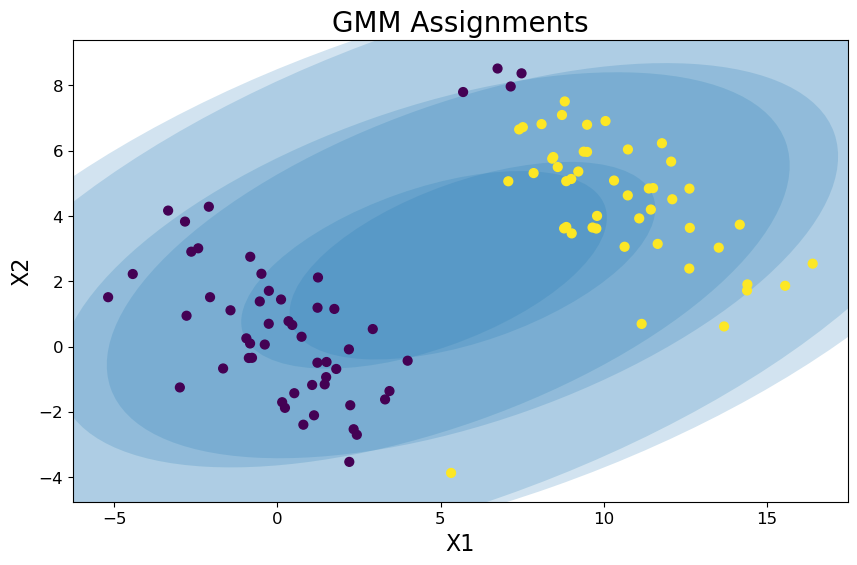

In [60]:
rng = np.random.default_rng(0)
gmm = GMModel(data, 2, rng)
gmm_plot(gmm, data)

As expected, the two clusters obtained from the randomly initialised GMM do not match the ground truth clusters at all because we first need to learn the parameters.

<a name="section-3"></a>
# Section 3: Fitting Gaussian Mixture Models using the EM algorithm ([index](#outline))

We employ the EM algorithm to fit the data. The algorithm iteratively updates parameters of the Gausian Mixture. The algorithm is guaranteed to improve (or at least not worsen) the marginal likelihood of the data. At iteration $t$ the algorithm performs following steps:


1. **Expectation step (E-step)**
The cluster probabilities are computed using the current parameter values, $\boldsymbol{\theta}^{(t)}$.

	The weights are updated from the cluster probabilities via
$$w_{ik}(\boldsymbol{\theta}^{(t)})=\frac{r_{ik}(\boldsymbol{\theta}^{(t)})}{\sum_{i'} r_{i'k}(\boldsymbol{\theta}^{(t)})}$$

2. **Maximisation step (M-step)**
The model's parameters for maximising the log-likelihood at the next iteration $(t+1)$ are found.

	The mixture weights are updated via:
$$
	\pi_k^{(t+1)} = \frac{1}{N}\sum_{i=1}^N r_{ik}(\boldsymbol{\theta}^{(t)}),
$$
and the cluster means are computed using a weighted mean:
$$	\boldsymbol{\mu}_k^{(t+1)} =\sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(t)}) \mathbf{x}^{(i)},$$
and similarly the covariances are updated via:
$$\boldsymbol{\Sigma}_k^{(t+1)}= \sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(t)}) (\mathbf{x}^{(i)}-\boldsymbol{\mu}_k^{(t+1)}) (\mathbf{x}^{(i)}-\boldsymbol{\mu}_k^{(t+1)})^T.$$



A single iteration of these steps is implemented in the following function:

In [63]:
## EDIT THIS FUNCTION
def gmm_fit_step(gmm, X):
    """
    Performs an EM iteration, updating all parameters via and E and M-step.

    Args:
        gmm (GMModel): the current GMM model.
        X (np.ndarray): the samples array, shape (N, p).

    Returns:
        gmm (GMModel): an updated GMM model after applying the E-M steps.
    """
    gmm = gmm.copy()

    # E-Step: compute probabilities and update weights holding mu/sigma/pi constant
    probabilities = cluster_probabilities(gmm, X) # <-- EDIT HERE
    weights = probabilities / np.sum(probabilities, axis=0) # <-- EDIT HERE

    # M-Step: update mu, sigma and pi holding probabilities and weights constant
    gmm.pi =  np.mean(weights, axis=0) # <-- EDIT HERE
    for i in range(gmm.k):
        gmm.mu[i] = weights[:, i] @ X # <-- EDIT HERE
        gmm.sigma[i] = ((X - gmm.mu[i]).T * weights[:, i]) @ (X - gmm.mu[i])

    return gmm

Let's make sure we pass the following test case.

In [64]:
rng = np.random.default_rng(0)
X_testing = np.array([[1.0, 2.0],
                      [3.0, -1.0],
                      [-3.0, 1.0]])
gmm_test = GMModel(X_testing, 2, rng)
gmm_test = gmm_fit_step(gmm_test, X_testing)
expected_mu = np.array([[-0.59852974,  1.24908109],
                        [ 1.76575382, -0.22859614]])
expected_sigma = [np.array([[ 5.04323241e+00, -3.30673111e-03],
                            [-3.30673111e-03,  7.89245088e-01]]),
                   np.array([[ 4.64786728, -1.82495164],
                             [-1.82495164,  1.41058613]])]
npt.assert_allclose(gmm_test.mu, expected_mu)
npt.assert_allclose(gmm_test.sigma, expected_sigma)

Implementing one EM iteration we see that it does not significantly improve the result:

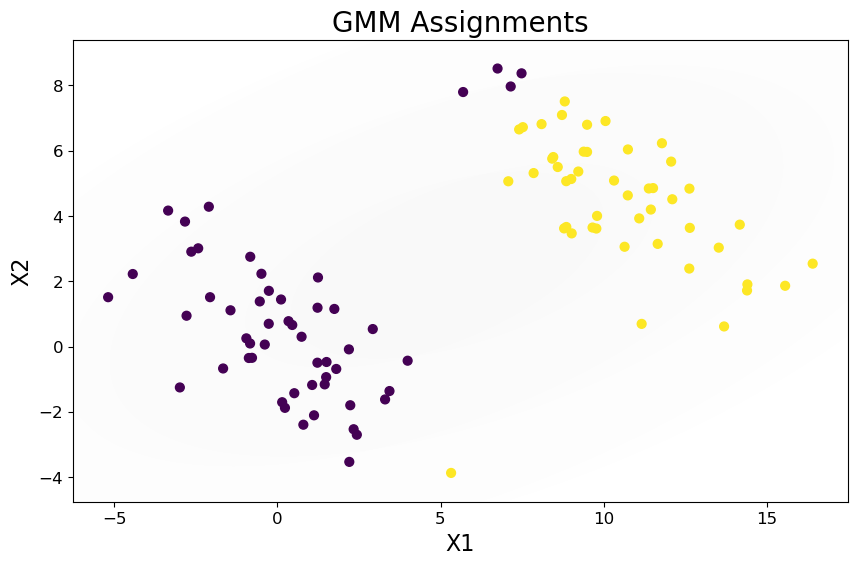

In [65]:
gmm = gmm_fit_step(gmm, data)
gmm_plot(gmm, data)

Let's see if we can observe some improvement after several iterations:

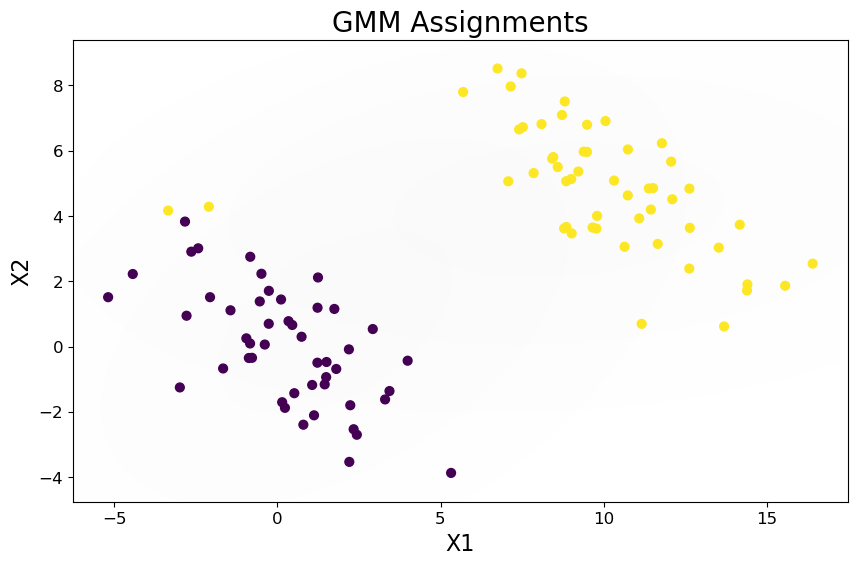

In [66]:
for _ in range(60):
    gmm = gmm_fit_step(gmm, data)
gmm_plot(gmm, data)

<a name="section-3"></a>
# Section 4: Clustering of breast cancer data ([index](#outline))

In this final section we will again work with the [Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data), which you can download directly from Blackboard. The data set contains various aspects of cell nuclei of breast screening images of patients with _(malignant)_ and without _(benign)_ breast cancer. Our goal is to cluster the data without the knowledge of the tumor being malignant or benign.

If you run this notebook locally on your machine, you will simply need to place the `csv` file in the same directory as this notebook.
If you run this notebook on Google Colab, you will need to use

  `from google.colab import files`

  `upload = files.upload()`

and then upload it from your local downloads directory.

In [ ]:
from google.colab import files

upload = files.upload()

In [ ]:
data = pd.read_csv('data.csv')
# print shape and last 10 rows
print(data.shape)

Let's have a look at the last ten rows to see what features the dataset describes.

In [ ]:
data.tail(10)

We now do some pre-processing steps:

In [ ]:
# drop last column (extra column added by pandas)
data = data.drop(data.columns[-1], axis=1)
# set column id as dataframe index, then drop that column
data = data.set_index(data['id']).drop(data.columns[0], axis=1)

# convert categorical labels to numbers
diag_map = {'M': 1.0, 'B': 0}
data['diagnosis'] = data['diagnosis'].map(diag_map)

# split target from features
y = np.asarray(data.loc[:, 'diagnosis'])
X = np.asarray(data.iloc[:, 1:])

data.tail(10)

We start by visualising the ground-truth labels with respect to two featurs, the Mean Radius and Mean Texture of the tumor.

In [ ]:
# plot for two features
fig = plt.figure(figsize=(10, 6))
labels = ['Malignant', 'Benign']
for i, c in enumerate(np.unique(y)):
    plt.scatter(X[:, 0][y==c], X[:, 1][y==c], label=labels[i])
plt.xlabel('Mean Radius')
plt.ylabel('Mean Texture')
plt.title('Ground truth of Diagnoses')
plt.xlim([5,30])
plt.legend()
plt.show()

In the following, we apply GMM clustering to the data set only using these two features (Mean Radius and Mean Texture).

In [ ]:
# restrict features
X = X[:, :2]

# initialise GMM model
rng = np.random.default_rng(0)
gmm2 = GMModel(X, 2, rng)

# plot prediction
gmm_plot(gmm2, X)
plt.xlabel('Mean Radius')
plt.ylabel('Mean Texture')
plt.title('Clustering of Diagnoses')
plt.ylim([5, 30])
plt.show()

After initialising our GMM model we can fit it to the data.

In [ ]:
for _ in range(100):
    gmm2 = gmm_fit_step(gmm2, X)
gmm_plot(gmm2, X)
plt.xlabel('Mean Radius')
plt.ylabel('Mean Texture')
plt.title('Clustering of Diagnoses')
plt.show()

Comparing this plot to that showing the ground truth of diagnosis, we see that we have largely recovered the structure of the two clusters. However, as expected it is less able to correctly separate those samples which fall in a region populated by both clusters.

**Questions:**

* How do you know that the EM algorithm converged?
* How could the clustering of the cancer data set be improved?
* Can you quantify the uncertainty of cluster assignments for the cancer data set?
* Can you think of caveats when optimising hyperparameters of GMMs?
* What are suitable criteria for clustering quality using mixture models?